In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm_notebook
from scipy.linalg import svd
import catboost
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Содержание

1. Понимание данных
2. Подготовка данных  
    2.1. "Схлопывание" повторяющихся действий пользователей  
    2.2. Фильтрация неактивных пользователей  
    2.3. Масштабирование данных  
    2.4. Разбиение выборки на тренировочную и тестовую
3. Моделирование и оценка  
    3.1. Метрики качества  
    3.2. Модель по полуярности (baseline)  
    3.3. Коллаборативная фильтрация  
        3.3.1. Memory-dased (user-based)  
        3.3.2. Latent Factor Model  
    3.4. Контентная модель  
        3.4.1. Предобработка данных и работа с признаками  
        3.4.2. RandomForestClassifier  
        3.4.3. CatBoostClassifier  
    3.5. Сравнение memory-based и LFM моделей

## 1. Понимание данных

In [2]:
path_transactions = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\transactions.csv"
path_clients = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\clients.csv"
path_categories = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\categories.csv"
path_subscriptions = r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\data\subscriptions.csv"

### subscriptions

In [3]:
subscriptions = pd.read_csv(path_subscriptions)
subscriptions.head()

,id,client_id,product_category,product_company,amount,date_start,date_end
0,766278,825,29,NaN,3990,2012-01-25,NaN
1,658393,709,4,Яндекс.Музыка,199,2012-01-27,2020-02-27
2,354548,383,4,Boom,149,2012-01-28,NaN
3,515830,556,4,Spotify,169,2012-02-01,NaN
4,799560,862,4,YouTube Music,169,2012-02-20,2020-05-20


In [4]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 7 columns):
id                  1308 non-null int64
client_id           1308 non-null int64
product_category    1308 non-null int64
product_company     801 non-null object
amount              1308 non-null int64
date_start          1308 non-null object
date_end            284 non-null object
dtypes: int64(4), object(3)
memory usage: 71.7+ KB


In [5]:
subscriptions.date_start = pd.to_datetime(subscriptions.date_start, format='%Y-%m-%d')
subscriptions.date_end = pd.to_datetime(subscriptions.date_end, format='%Y-%m-%d')

#### product_category

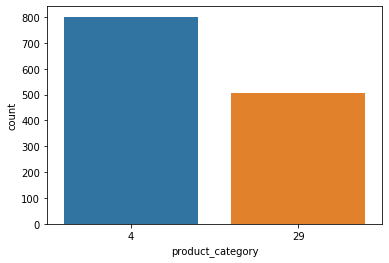

In [6]:
sns.countplot(subscriptions.product_category);

#### product_company

In [7]:
subscriptions.loc[subscriptions.product_company.isnull() == True].shape[0] == subscriptions.query('product_category == 29').shape[0]

True

Получаем, что пропуски в данном столбце соответствуют только 29 категории.

In [8]:
subscriptions.loc[subscriptions.product_company.isnull() == True, 'product_company'] = 'company_29'

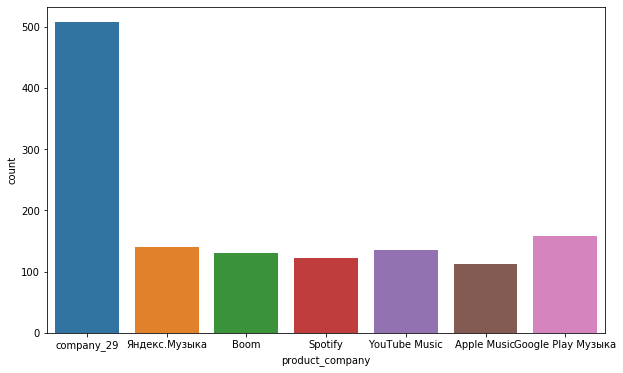

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(subscriptions.product_company, ax=ax);

#### amount

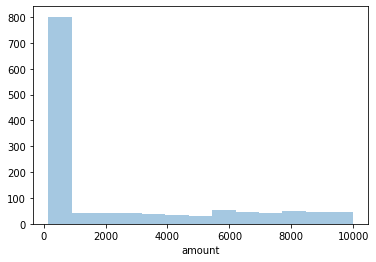

In [10]:
sns.distplot(subscriptions.amount, kde=False);

#### date_end

Пропуски в данном столбце означают то, что клиент все еще по-прежнему подписан на данную категорию. Создадим бинарный столбец, который говорит о том, подписан ли клиент на данну категорию.

In [11]:
subscriptions.loc[subscriptions['date_end'].isnull() != True, 'is_subscription'] = 1
subscriptions.loc[subscriptions['date_end'].isnull() == True, 'is_subscription'] = 0

#### is_subscriptions

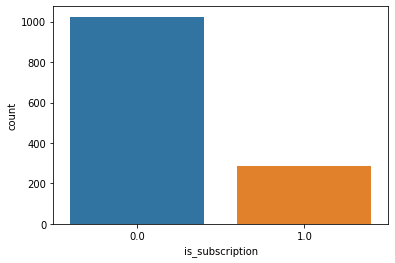

In [12]:
sns.countplot(subscriptions.is_subscription);

### clients

In [13]:
clients = pd.read_csv(path_clients)
clients.head()

,id,fullname,address,phone_number,email,workplace,birthdate,registration_date,gender,income,expenses,credit,deposit
0,1,Волкова Фаина Афанасьевна,"с. Новосибирск, наб. Привокзальная, д. 58 к. 5...",8 (475) 014-6494,wkirillov@rambler.ru,"ст. Кировск (Мурм.), ш. Коммуны, д. 238 стр. 3...",1966-09-07,2017-01-10,F,230910.0,61975,1.0,NaN
1,2,Пелагея Вячеславовна Галкина,"клх Белокуриха, ш. Комсомольское, д. 701 стр. ...",+7 (981) 576-1146,bogdanovmoke@rambler.ru,"г. Елабуга, бул. 60 лет Октября, д. 5, 070955",1987-05-23,2016-07-14,F,NaN,75232,NaN,NaN
2,3,Валентина Игоревна Фомина,"к. Усть-Катав, бул. Восточный, д. 292 стр. 3, ...",+7 (920) 068-58-36,mjasnikovvalentin@mail.ru,"г. Сосновый Бор, алл. Лесхозная, д. 146, 139446",1974-06-15,2017-10-18,F,NaN,88813,NaN,NaN
3,4,тов. Воронцова Фёкла Федоровна,"клх Новая Игирма, алл. Пограничная, д. 6/6, 73...",8 334 398 3828,martin85@rambler.ru,"клх Котельнич, бул. Серафимовича, д. 97, 753076",1979-10-19,2012-08-25,F,NaN,55167,NaN,NaN
4,5,Филипп Дмитриевич Воронцов,"к. Ребриха, пр. Свободы, д. 54, 466509",8 (296) 455-0453,jan_07@rambler.ru,"клх Карабудахкент, ул. Абрикосовая, д. 3 к. 19...",1986-08-14,2017-03-15,M,NaN,85106,NaN,NaN


In [14]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
id                   1000 non-null int64
fullname             1000 non-null object
address              1000 non-null object
phone_number         1000 non-null object
email                1000 non-null object
workplace            1000 non-null object
birthdate            1000 non-null object
registration_date    1000 non-null object
gender               1000 non-null object
income               364 non-null float64
expenses             1000 non-null int64
credit               364 non-null float64
deposit              376 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 101.7+ KB


In [15]:
clients.id = clients.id.astype('str')
clients = clients.rename(columns={'id': 'client_id'})
clients.birthdate = pd.to_datetime(clients.birthdate, format='%Y-%m-%d')
clients.registration_date = pd.to_datetime(clients.registration_date, format='%Y-%m-%d')

#### expenses

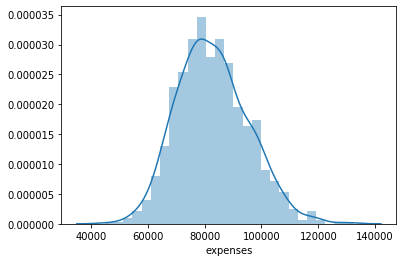

In [16]:
sns.distplot(clients.expenses);

#### income

Заполним пропуски в данном столбце средним значением для тех клиентов, у которых не удалось определить значение среднего месячного дохода за последний год.

In [17]:
mean = clients.loc[clients['income'].isnull() != True, 'income'].mean()
clients.loc[clients['income'].isnull() == True, 'income'] = mean

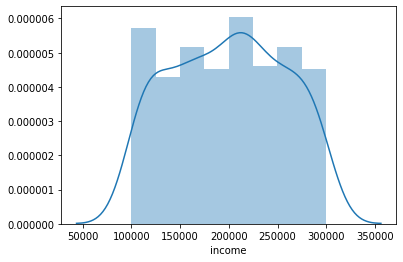

In [18]:
sns.distplot(clients.query('income != @mean')['income']); # уберем пользователей, у которых изначально отсутствовало значение income

#### credit

Заполним пропуски в данном столбце 0, что говорит о том, что клиент не брал кредит в банке.

In [19]:
clients.loc[clients['credit'].isnull() == True, 'credit'] = 0
clients.credit = clients.credit.astype('int')

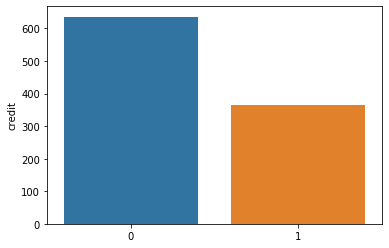

In [20]:
sns.barplot(x=clients.credit.value_counts().index, y=clients.credit.value_counts());

#### deposit

Заполним пропуски в данном столбце 0, что говорит о том, что клиент не брал депозит в банке.

In [21]:
clients.loc[clients['deposit'].isnull() == True, 'deposit'] = 0
clients.deposit = clients.deposit.astype('int')

In [22]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
client_id            1000 non-null object
fullname             1000 non-null object
address              1000 non-null object
phone_number         1000 non-null object
email                1000 non-null object
workplace            1000 non-null object
birthdate            1000 non-null datetime64[ns]
registration_date    1000 non-null datetime64[ns]
gender               1000 non-null object
income               1000 non-null float64
expenses             1000 non-null int64
credit               1000 non-null int32
deposit              1000 non-null int32
dtypes: datetime64[ns](2), float64(1), int32(2), int64(1), object(7)
memory usage: 93.9+ KB


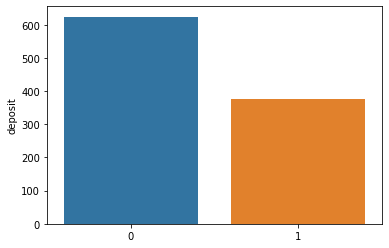

In [23]:
sns.barplot(x=clients.deposit.value_counts().index, y=clients.deposit.value_counts());

### categories

In [24]:
categories = pd.read_csv(path_categories)
categories

,id,name,description,mcc-code
0,1,Каршеринг,Краткосрочная аренда авто с оплатой по минутам...,"7512, 4121"
1,2,Супермаркеты,Покупки в супермаркетах и продуктовых магазинах,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451..."
2,3,Такси,Услуги такси (каршеринг не входит в данную кат...,4121
3,4,Музыка,Покупки в магазинах музыки и музыкальных инстр...,"5733, 5735"
4,5,Фастфуд,Покупки в ресторанах быстрого питания,5814
5,6,Транспорт,Оплата городского и пригородного транспорта. В...,"4111, 4121, 4131, 4457, 4468, 4784, 4789, 5013..."
6,7,Аптеки,Покупки в аптеках,"5122, 5292, 5295, 5912"
7,8,Кино,Покупки в кинотеатрах и магазинах кино,"7829, 7832, 7841"
8,9,Книги,Покупки в книжных магазинах и газетных киосках,"2741, 5111, 5192, 5942, 5994"
9,10,Развлечения,"Оплата развлечений, (например, в магазинах вид...","7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992..."


In [25]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 4 columns):
id             29 non-null int64
name           29 non-null object
description    29 non-null object
mcc-code       27 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [26]:
categories.id = categories.id.astype('str')
categories['mcc-code'] = categories['mcc-code'].fillna('no_code')
categories['mcc-code'] = categories['mcc-code'].astype('str')
categories = categories.rename(columns={'id': 'product_category'})

### transactions

In [27]:
transactions = pd.read_csv(path_transactions)
transactions.head()

,Unnamed: 0,client_id,product_category,product_company,subtype,amount,date,transaction_type
0,34478,37,29,NaN,Автоплатеж,1209,2020-01-01 00:00:00,Negative
1,65406,71,4,YouTube Music,Подписка,169,2020-01-01 00:00:00,Negative
2,82186,88,29,NaN,Автоплатеж,3711,2020-01-01 00:00:00,Negative
3,83113,89,29,NaN,Автоплатеж,6443,2020-01-01 00:00:00,Negative
4,131373,141,29,NaN,Автоплатеж,7319,2020-01-01 00:00:00,Negative


In [28]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929135 entries, 0 to 929134
Data columns (total 8 columns):
Unnamed: 0          929135 non-null int64
client_id           929135 non-null int64
product_category    929135 non-null int64
product_company     644651 non-null object
subtype             929135 non-null object
amount              929135 non-null int64
date                929135 non-null object
transaction_type    929135 non-null object
dtypes: int64(4), object(4)
memory usage: 56.7+ MB


In [29]:
transactions.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
transactions.product_category = transactions.product_category.astype('str')
transactions.client_id = transactions.client_id.astype('str')
transactions.id = transactions.id.astype('str')
transactions.date = pd.to_datetime(transactions.date, format='%Y-%m-%d %H:%M:%S')

#### transaction_type

В нашем анализе для построения рекомендательной системы нужны те транзакции клиентов, которые говорят о том, что они приобрели ту или иную категорию товара или услуги, а не получили денежный перевод от кого-либо, поэтому уберем все транзакции, которые имеют transaction_type, равный Positive.

In [30]:
transactions.transaction_type.unique()

array(['Negative', 'Positive'], dtype=object)

In [31]:
transactions = transactions.query('transaction_type != "Positive"')

In [32]:
transactions.shape

(884151, 8)

#### product_category

Проанализировав имеющиеся категории товаров и услуг заметим, что категория 28 - Переводы (переводы, пополнения). Уберем все транзакции, в которых содержится данная категория, так как данную категорию нельзя связвать со спецификой решаемой задачи.

In [33]:
transactions = transactions.query('product_category != "28"')

In [34]:
transactions.shape

(839117, 8)

Также уберем категорию 29 - Другое (интернет, коммунальные услуги), поскольку в ней смешаны несколько разных услуг и данную категорию также нельзя связать со спецификой решаемой задачи.

In [35]:
transactions = transactions.query('product_category != "29"')

In [36]:
transactions.shape

(833931, 8)

In [37]:
transactions.reset_index(inplace=True, drop=True)

In [38]:
transactions.product_category.value_counts()

6     350044
5     130137
2      45010
3      29839
1      29563
8      24225
9      24208
11     24087
14     24035
10     24007
7      23924
13     23877
15     16973
17      9191
20      9160
21      9154
16      9122
18      9108
19      9068
4       8004
12       427
26       142
27       136
22       134
24       126
25       122
23       108
Name: product_category, dtype: int64

#### subtype

In [39]:
transactions.subtype.value_counts()

Покупка     825927
Подписка      8004
Name: subtype, dtype: int64

#### product_company

Заполним пропуски в данном столбце на значение no_company.

In [40]:
transactions.loc[transactions.product_company.isnull() == True, 'product_company'] = 'no_company'

In [41]:
transactions.product_company.value_counts()

no_company                 189280
Московский Метрополитен    116903
Стрелка                    116124
Тануки                      16513
PizzaHut                    16362
                            ...  
Boom                         1395
Яндекс.Музыка                1370
YouTube Music                1352
Spotify                      1184
Apple Music                  1131
Name: product_company, Length: 69, dtype: int64

#### amount

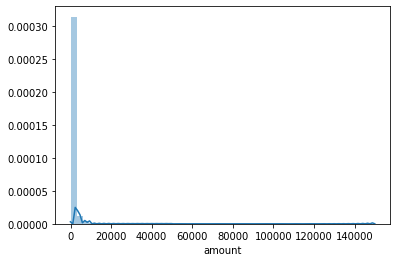

In [42]:
sns.distplot(transactions.amount);

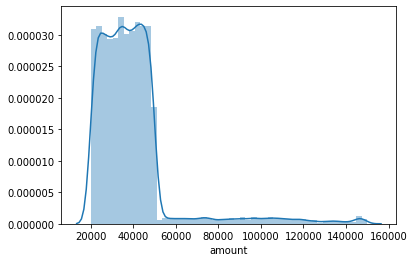

In [43]:
sns.distplot(transactions.query('amount > 20000')['amount']);

In [44]:
transactions_part = transactions[['client_id', 'product_category', 'date']]
transactions_part.head()

,client_id,product_category,date
0,71,4,2020-01-01
1,225,4,2020-01-01
2,295,4,2020-01-01
3,317,4,2020-01-01
4,336,4,2020-01-01


## 2. Подготовка данных

### 2.1. "Схлопывание" повторяющихся действий пользователей

Для каждого пользователя посчитаем количество того, сколько раз он взаимодействовал с каждой категорией товара в данных транзакций.

In [45]:
data = transactions_part.groupby(['client_id', 'product_category'], as_index=False) \
    .agg({'date': 'count'}) \
    .rename(columns={'date': 'purchase_count'})

In [46]:
data.head()

,client_id,product_category,purchase_count
0,1,10,18
1,1,11,14
2,1,13,23
3,1,14,19
4,1,16,10


### 2.2. Фильтрация неактивных пользователей

Отфильтруем пользователей, которые взаимодействовали не больше, чем с 4 категориями товаров и услуг.

In [47]:
users_interactions = data \
    .groupby('client_id', as_index=False) \
    .agg({'product_category': 'count'}) \
    .rename(columns={'product_category': 'unique_categories'})
users_interactions.head()

,client_id,unique_categories
0,1,17
1,10,19
2,100,20
3,1000,20
4,101,19


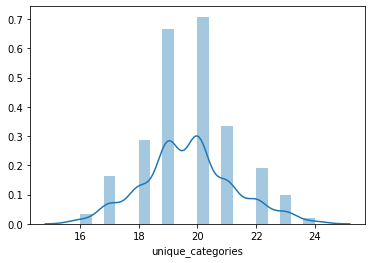

In [48]:
sns.distplot(users_interactions.unique_categories);

In [49]:
users_with_enough_interactions = users_interactions.query('unique_categories > 4')['client_id']
users_with_enough_interactions

0         1
1        10
2       100
3      1000
4       101
       ... 
995     995
996     996
997     997
998     998
999     999
Name: client_id, Length: 1000, dtype: object

In [50]:
print(f'Всего пользователей: {users_interactions.shape[0]}')
print(f'Пользователей по крайней мере с 5 взаимодействиями: {users_with_enough_interactions.shape[0]}')

Всего пользователей: 1000
Пользователей по крайней мере с 5 взаимодействиями: 1000


Получаем, что пользователей меньше, чем с 5 взаимодействиями нет.

### 2.3. Масштабирование данных

В качестве масштабирования данных воспользуемся MinMaxScaler.

In [51]:
data = data.assign(purchase_normalize = (data.purchase_count - data.purchase_count.min()) / (data.purchase_count.max() - data.purchase_count.min()))
data.drop(columns=['purchase_count'], inplace=True)
data.head()

,client_id,product_category,purchase_normalize
0,1,10,0.042607
1,1,11,0.032581
2,1,13,0.055138
3,1,14,0.045113
4,1,16,0.022556


### 2.4. Разбиение выборки на тренировочную и тестовую

Произведем разбиение выборки на обучение и контроль по времени. Перед этим возьмем последнее время взаимодействия пары client_id и product_category.

In [52]:
transactions_last_date = transactions_part \
    .groupby(['client_id', 'product_category'], as_index=False) \
    .date \
    .last()
transactions_last_date.head()

,client_id,product_category,date
0,1,10,2020-12-22 02:33:13
1,1,11,2020-12-22 10:20:44
2,1,13,2020-12-29 09:07:06
3,1,14,2020-12-31 06:49:11
4,1,16,2020-12-29 03:38:07


In [53]:
data = data \
    .merge(transactions_last_date, on=['client_id', 'product_category']) \
    .rename(columns={'date': 'last_date'})
data.head()

,client_id,product_category,purchase_normalize,last_date
0,1,10,0.042607,2020-12-22 02:33:13
1,1,11,0.032581,2020-12-22 10:20:44
2,1,13,0.055138,2020-12-29 09:07:06
3,1,14,0.045113,2020-12-31 06:49:11
4,1,16,0.022556,2020-12-29 03:38:07


In [54]:
split_date = '2020-12-30'
data_train = data.query('last_date < @split_date').copy()
data_test = data.query('last_date >= @split_date').copy()

print(f'Всего взаимодействий: {data.shape[0]}')
print(f'Доля взаимодействий в тренировочной выборке: {round(data_train.shape[0] / data.shape[0], 1)} ({data_train.shape[0]})')
print(f'Доля взаимодействий в тестовой выборке: {round(data_test.shape[0] / data.shape[0], 1)} ({data_test.shape[0]})')

Всего взаимодействий: 19694
Доля взаимодействий в тренировочной выборке: 0.8 (16544)
Доля взаимодействий в тестовой выборке: 0.2 (3150)


Для удобства подсчета качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [55]:
data_true = (
    data_train
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'product_category': 'true_train'})
    .set_index('client_id')
)

data_true['true_test'] = (
    data_test
    .groupby('client_id')['product_category'].agg(lambda x: list(x))
)

Заполним пропуски пустыми списками.

In [56]:
data_true.loc[pd.isnull(data_true.true_test), 'true_test'] = [
    list() for x in range(len(data_true.loc[pd.isnull(data_true.true_test), 'true_test']))]

In [57]:
data_true.head(1)

,true_train,true_test
client_id,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 5, 9]"


## 3. Моделирование и оценка

Для каждого пользователя будем предсказывать только одну категорию товара или услуги в связи тем, что реклама только одной категории товара или услуги может быть показана пользователю в приложении.

### 3.1. Метрики качества

В качестве метрик качества моделей рассчитаем следующие:
- precision@k;
- recall@k;
- F-score@k.

За основную метрику возьмем F-score@k.

In [58]:
top_k = 1 # количество категорий, которое нужно предсказать пользователю

In [59]:
def calc_precision(column):
    return (
        data_true
            .apply(
                lambda row: len(set(row['true_test']).intersection(row[column])) / min(len(row['true_test']) + 0.001, top_k),
                axis=1
            )
    ).mean()

In [60]:
def calc_recall(column):
    return (
        data_true
            .apply(
                lambda row: len(set(row['true_test']).intersection(row[column])) / min(len(row[column]) + 0.001, top_k),
                axis=1
            )
    ).mean()

При прогнозировании нам важнее то, чтобы модель рекомендательной системы не рекомендовала пользователям то, что им не интересно, поэтому строя и оценивая наши модели, будем использовать измененную метрику качества F-score, в которой дадим больший вес точности (precision@k).

In [61]:
def calc_fscore_precision(column):
    beta = 0.5
    precision = calc_precision(column)
    recall = calc_recall(column)
    fscore_precision = ((1 + beta ** 2) * precision * recall) / (beta ** 2 * precision + recall)
    return fscore_precision

### 3.2. Модель по полуярности (baseline)

Посчитаем популярность каждой категории, как сумму всех количеств взаимодействия с ней, и отсортируем категории по их популярности.

In [62]:
popular_category = (
    data_train
    .groupby('product_category', as_index=False)
    .agg({'purchase_normalize': 'sum'})
    .rename(columns={'purchase_normalize': 'purchase_total'})
    .sort_values('purchase_total', ascending=False)
    .product_category.values
)
popular_category

array(['5', '6', '2', '3', '1', '7', '11', '8', '13', '10', '14', '9',
       '15', '17', '21', '20', '16', '18', '19', '4', '12', '26', '27',
       '24', '25', '22', '23'], dtype=object)

In [63]:
print(f"Наиболее популярной категорией является: {categories.query('product_category == @popular_category[0]')['name'].values[0]}")
print(f"Наименее популярной категорией является: {categories.query('product_category == @popular_category[-1]')['name'].values[0]}")

Наиболее популярной категорией является: Фастфуд
Наименее популярной категорией является: Автоуслуги


Делаем предсказания для каждого пользователя.

Рекомендуем каждому пользователю те категории товаров и услуг, которые он приобретал и которые еще нет. В этом случае каждому пользователю предлагаем самую популярную категорию.

In [64]:
data_true['prediction_popular_without'] = np.resize(popular_category[:top_k], (data_true.shape[0], 1))

In [65]:
data_true.head()

,true_train,true_test,prediction_popular_without
client_id,,,
1,"[10, 11, 13, 16, 17, 18, 19, 2, 20, 21, 4, 6, ...","[14, 5, 9]",5
10,"[1, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 26...","[2, 6]",5
100,"[1, 10, 12, 13, 14, 16, 17, 18, 19, 2, 20, 21,...","[11, 5, 6, 9]",5
1000,"[1, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 3,...","[10, 2, 6, 7]",5
101,"[1, 10, 11, 13, 14, 16, 17, 18, 19, 2, 20, 21,...",[6],5


In [66]:
print(f'Precision@1: {calc_precision("prediction_popular_without")}')
print(f'Recall@1: {calc_recall("prediction_popular_without")}')
print(f'F-score@1: {calc_fscore_precision("prediction_popular_without")}')

Precision@1: 0.524
Recall@1: 0.524
F-score@1: 0.524


### 3.3. Коллаборативная фильтрация

In [67]:
data_matrix = pd.pivot_table(data, index='client_id', columns='product_category', values='purchase_normalize', fill_value=0)
data_matrix.head()

product_category,1,10,11,12,13,14,15,16,17,18,...,25,26,27,3,4,5,6,7,8,9
client_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.042607,0.032581,0.0,0.055138,0.045113,0.000000,0.022556,0.012531,0.040100,...,0.0,0.0,0.0,0.000000,0.027569,0.378446,0.974937,0.065163,0.060150,0.047619
10,0.102757,0.050125,0.065163,0.0,0.070175,0.050125,0.000000,0.015038,0.022556,0.030075,...,0.0,0.0,0.0,0.082707,0.000000,0.273183,0.784461,0.050125,0.065163,0.047619
100,0.110276,0.030075,0.045113,0.0,0.030075,0.035088,0.000000,0.025063,0.035088,0.030075,...,0.0,0.0,0.0,0.067669,0.020050,0.283208,0.781955,0.035088,0.047619,0.062657
1000,0.080201,0.075188,0.077694,0.0,0.057644,0.065163,0.117794,0.012531,0.010025,0.020050,...,0.0,0.0,0.0,0.080201,0.027569,0.338346,0.979950,0.075188,0.072682,0.067669
101,0.067669,0.067669,0.082707,0.0,0.090226,0.057644,0.000000,0.020050,0.015038,0.022556,...,0.0,0.0,0.0,0.110276,0.007519,0.338346,0.862155,0.077694,0.082707,0.057644


#### 3.3.1. Memory-dased (user-based)

In [68]:
matrix = data_matrix.values

In [69]:
similarity_users = np.zeros((len(matrix), len(matrix)))

for i in tqdm_notebook(range(len(matrix))):
    for j in range(i+1, len(matrix)):
        
        mask_uv = (matrix[i] != 0) & (matrix[j] != 0)
        
        if np.sum(mask_uv) == 0:
            continue
            
        ratings_v = matrix[i, mask_uv]
        ratings_u = matrix[j, mask_uv]
        
        if len(np.unique(ratings_v)) < 2 or len(np.unique(ratings_u)) < 2:
            continue
        similarity_users[i,j] = np.corrcoef(ratings_v, ratings_u)[0, 1]
        similarity_users[j,i] = similarity_users[i,j]

В нашем примере данных не очень много, поэтому возьмём $\alpha = 0$.

In [70]:
prediction_user_based = []
for i in tqdm_notebook(range(len(similarity_users))):
    users_sim = similarity_users[i] > 0
    if len(users_sim) == 0:
        prediction_user_based.append([])
    else:
        tmp_recommend = np.argsort(matrix[users_sim].sum(axis=0))[::-1]
        tmp_recommend = data_matrix.columns[tmp_recommend]
        recommend = np.array(tmp_recommend)[:1] #***
        prediction_user_based.append(list(recommend))

data_true['prediction_user_based'] = prediction_user_based

In [71]:
print(f'Precision@1: {calc_precision("prediction_user_based")}')
print(f'Recall@1: {calc_recall("prediction_user_based")}')
print(f'F-score@1: {calc_fscore_precision("prediction_user_based")}')

Precision@1: 0.855
Recall@1: 0.855
F-score@1: 0.855


#### 3.3.2. Latent Factor Model

In [72]:
U, sigma, V = svd(data_matrix)
print(data_matrix.shape, U.shape, sigma.shape, V.shape)

(1000, 27) (1000, 1000) (27,) (27, 27)


In [73]:
Sigma = np.zeros((1000, 27))
Sigma[:27, :27] = np.diag(sigma)

new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))

9.463168292693107e-26


Значения у матрицы с сингулярными числами отсортированы по убыванию. Оставим только первые 25 компонент и получим скрытые представления размерности 25.

In [74]:
K = 25
sigma[K:] = 0
Sigma = np.zeros((1000, 27))
Sigma[:27, :27] = np.diag(sigma)

In [75]:
new_data_matrix = U.dot(Sigma).dot(V)
print(sum(sum((new_data_matrix - data_matrix.values) ** 2)))
print(sum(sum((data_matrix.values.mean() - data_matrix.values) ** 2)))

0.00024670313819872284
782.1063944626712


In [76]:
new_data_matrix = pd.DataFrame(new_data_matrix, index=data_matrix.index, columns=data_matrix.columns)

predictions = []
for client_id in tqdm_notebook(data_true.index):
    prediction = (
        new_data_matrix
        .loc[client_id]
        .sort_values(ascending=False)
        .index.values
    )
    
    predictions.append(
        list(prediction)[:top_k]) #***

data_true['prediction_svd'] = predictions

In [77]:
print(f'Precision@1: {calc_precision("prediction_svd")}')
print(f'Recall@1: {calc_recall("prediction_svd")}')
print(f'F-score@1: {calc_fscore_precision("prediction_svd")}')

Precision@1: 0.855
Recall@1: 0.855
F-score@1: 0.855


### 3.4. Контентная модель

In [78]:
test_client_id = np.repeat(data_true.index, len(data_matrix.columns)) 
test_product_category = list(data_matrix.columns) * len(data_true)
test = pd.DataFrame(
    np.array([test_client_id, test_product_category]).T,
    columns=['client_id', 'product_category'])

data_train_content = pd.concat((
    data_train,
    test.loc[
        np.random.permutation(test.index)[
            :4*len(data_train)]]), ignore_index=True)
data_train.purchase_normalize.fillna(0, inplace=True)

C:\Users\kiril\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [79]:
data_train_content.head()

,client_id,last_date,product_category,purchase_normalize
0,1,2020-12-22 02:33:13,10,0.042607
1,1,2020-12-22 10:20:44,11,0.032581
2,1,2020-12-29 09:07:06,13,0.055138
3,1,2020-12-29 03:38:07,16,0.022556
4,1,2020-11-11 05:21:46,17,0.012531


In [80]:
features_start = len(data_train_content.columns)
features_start

4

#### 3.4.1. Предобработка данных и работа с признаками

Добавим данные о категориях и о клиентах.

In [81]:
data_train_content = data_train_content.merge(categories, how='left', on='product_category')
data_train_content = data_train_content.merge(clients[['client_id', 'birthdate', 'registration_date', 'gender', 'income', 'expenses', 'credit', 'deposit']], how='left', on='client_id')

In [82]:
data_train_content.drop(columns=['name', 'description'], inplace=True)

In [83]:
data_train_content.head()

,client_id,last_date,product_category,purchase_normalize,mcc-code,birthdate,registration_date,gender,income,expenses,credit,deposit
0,1,2020-12-22 02:33:13,10,0.042607,"7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992...",1966-09-07,2017-01-10,F,230910.0,61975,1,0
1,1,2020-12-22 10:20:44,11,0.032581,"5977, 7230, 7297, 7298",1966-09-07,2017-01-10,F,230910.0,61975,1,0
2,1,2020-12-29 09:07:06,13,0.055138,"5094, 5137, 5139, 5611, 5621, 5631, 5641, 5651...",1966-09-07,2017-01-10,F,230910.0,61975,1,0
3,1,2020-12-29 03:38:07,16,0.022556,"5995, 0742",1966-09-07,2017-01-10,F,230910.0,61975,1,0
4,1,2020-11-11 05:21:46,17,0.012531,"1520, 1711, 1731, 1740, 1750, 1761, 1771, 1799...",1966-09-07,2017-01-10,F,230910.0,61975,1,0


Добавим данные о паре user-category: посчитаем то, на какую сумму пользователем было приобретено товаров и услуг каждой категории; также возьмем в транзакциях последний тип subtype и product_company.

In [84]:
last_subtype_company = transactions_last_date.merge(transactions[['client_id','product_category', 'date', 'subtype', 'product_company']], how='left', on=['client_id','product_category', 'date'])
last_subtype_company.head()

,client_id,product_category,date,subtype,product_company
0,1,10,2020-12-22 02:33:13,Покупка,Боулинг клуб Самокат
1,1,11,2020-12-22 10:20:44,Покупка,Парикмахерская DIMAX
2,1,13,2020-12-29 09:07:06,Покупка,Bershka
3,1,14,2020-12-31 06:49:11,Покупка,Своя компания
4,1,16,2020-12-29 03:38:07,Покупка,no_company


In [85]:
sum_amount = transactions.groupby(['client_id', 'product_category'], as_index=False) \
    .agg({'amount': 'sum'}) \
    .rename(columns={'amount': 'sum_amount'})
sum_amount.head()

,client_id,product_category,sum_amount
0,1,10,9707
1,1,11,21380
2,1,13,130068
3,1,14,32328
4,1,16,7885


In [86]:
user_category_features = sum_amount.merge(last_subtype_company, on=['client_id', 'product_category'])
user_category_features.head()

,client_id,product_category,sum_amount,date,subtype,product_company
0,1,10,9707,2020-12-22 02:33:13,Покупка,Боулинг клуб Самокат
1,1,11,21380,2020-12-22 10:20:44,Покупка,Парикмахерская DIMAX
2,1,13,130068,2020-12-29 09:07:06,Покупка,Bershka
3,1,14,32328,2020-12-31 06:49:11,Покупка,Своя компания
4,1,16,7885,2020-12-29 03:38:07,Покупка,no_company


In [87]:
data_train_content = data_train_content.merge(user_category_features, how='left', on=['client_id', 'product_category'])
data_train_content.head()

,client_id,last_date,product_category,purchase_normalize,mcc-code,birthdate,registration_date,gender,income,expenses,credit,deposit,sum_amount,date,subtype,product_company
0,1,2020-12-22 02:33:13,10,0.042607,"7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992...",1966-09-07,2017-01-10,F,230910.0,61975,1,0,9707.0,2020-12-22 02:33:13,Покупка,Боулинг клуб Самокат
1,1,2020-12-22 10:20:44,11,0.032581,"5977, 7230, 7297, 7298",1966-09-07,2017-01-10,F,230910.0,61975,1,0,21380.0,2020-12-22 10:20:44,Покупка,Парикмахерская DIMAX
2,1,2020-12-29 09:07:06,13,0.055138,"5094, 5137, 5139, 5611, 5621, 5631, 5641, 5651...",1966-09-07,2017-01-10,F,230910.0,61975,1,0,130068.0,2020-12-29 09:07:06,Покупка,Bershka
3,1,2020-12-29 03:38:07,16,0.022556,"5995, 0742",1966-09-07,2017-01-10,F,230910.0,61975,1,0,7885.0,2020-12-29 03:38:07,Покупка,no_company
4,1,2020-11-11 05:21:46,17,0.012531,"1520, 1711, 1731, 1740, 1750, 1761, 1771, 1799...",1966-09-07,2017-01-10,F,230910.0,61975,1,0,122239.0,2020-11-11 05:21:46,Покупка,no_company


Расчитаем то, сколько дней прошло с момента регистрации пользователя и последним взаимодействием с каждой категорией. Также посчитаем то, сколько примерно лет было пользователю на момент последней покупки каждой категории.

In [88]:
data_train_content['days_from_registration'] = data_train_content['date'].subtract(data_train_content['registration_date']).dt.days
mean_days_from_registration = data_train_content.loc[data_train_content['days_from_registration'].isnull() != True, 'days_from_registration'].mean()
data_train_content.loc[data_train_content['days_from_registration'].isnull() == True, 'days_from_registration'] = mean_days_from_registration
data_train_content.days_from_registration = data_train_content.days_from_registration.astype(int)

In [89]:
data_train_content['age'] = data_train_content['date'].subtract(data_train_content['birthdate']).dt.days.div(365).round()
mean_age = round(data_train_content.loc[data_train_content['age'].isnull() != True, 'age'].mean())
data_train_content.loc[data_train_content['age'].isnull() == True, 'age'] = mean_age
data_train_content.age = data_train_content.age.astype(int)

In [90]:
data_train_content.drop(columns=['date', 'registration_date', 'birthdate'], inplace=True)

In [91]:
data_train_content.head()

,client_id,last_date,product_category,purchase_normalize,mcc-code,gender,income,expenses,credit,deposit,sum_amount,subtype,product_company,days_from_registration,age
0,1,2020-12-22 02:33:13,10,0.042607,"7911, 7922, 7929, 7932, 7933, 7941, 7991, 7992...",F,230910.0,61975,1,0,9707.0,Покупка,Боулинг клуб Самокат,1442,54
1,1,2020-12-22 10:20:44,11,0.032581,"5977, 7230, 7297, 7298",F,230910.0,61975,1,0,21380.0,Покупка,Парикмахерская DIMAX,1442,54
2,1,2020-12-29 09:07:06,13,0.055138,"5094, 5137, 5139, 5611, 5621, 5631, 5641, 5651...",F,230910.0,61975,1,0,130068.0,Покупка,Bershka,1449,54
3,1,2020-12-29 03:38:07,16,0.022556,"5995, 0742",F,230910.0,61975,1,0,7885.0,Покупка,no_company,1449,54
4,1,2020-11-11 05:21:46,17,0.012531,"1520, 1711, 1731, 1740, 1750, 1761, 1771, 1799...",F,230910.0,61975,1,0,122239.0,Покупка,no_company,1401,54


In [92]:
test_client_id = np.repeat(data_true.index, len(categories)) 
test_product_category = list(categories.product_category) * len(data_true)
data_test_content = pd.DataFrame(
    np.array([test_client_id, test_product_category]).T,
    columns=['client_id', 'product_category'])
data_test_content = data_test_content.merge(categories, how='left', on='product_category')
data_test_content = data_test_content.merge(clients[['client_id', 'birthdate', 'registration_date', 'gender', 'income', 'expenses', 'credit', 'deposit']], how='left', on='client_id')
data_test_content.drop(columns=['name', 'description'], inplace=True)

In [93]:
data_test_content = data_test_content.merge(user_category_features, how='left', on=['client_id', 'product_category'])

In [94]:
data_test_content['days_from_registration'] = data_test_content['date'].subtract(data_test_content['registration_date']).dt.days
mean_days_from_registration = data_test_content.loc[data_test_content['days_from_registration'].isnull() != True, 'days_from_registration'].mean()
data_test_content.loc[data_test_content['days_from_registration'].isnull() == True, 'days_from_registration'] = mean_days_from_registration
data_test_content.days_from_registration = data_test_content.days_from_registration.astype(int)

In [95]:
data_test_content['age'] = data_test_content['date'].subtract(data_test_content['birthdate']).dt.days.div(365).round()
mean_age = round(data_test_content.loc[data_test_content['age'].isnull() != True, 'age'].mean())
data_test_content.loc[data_test_content['age'].isnull() == True, 'age'] = mean_age
data_test_content.age = data_test_content.age.astype(int)

In [96]:
data_test_content.drop(columns=['date'], inplace=True)

In [97]:
data_test_content.head()

,client_id,product_category,mcc-code,birthdate,registration_date,gender,income,expenses,credit,deposit,sum_amount,subtype,product_company,days_from_registration,age
0,1,1,"7512, 4121",1966-09-07,2017-01-10,F,230910.0,61975,1,0,NaN,NaN,NaN,1795,39
1,1,2,"5297, 5298, 5300, 5411, 5412, 5422, 5441, 5451...",1966-09-07,2017-01-10,F,230910.0,61975,1,0,124999.0,Покупка,Ашан,1445,54
2,1,3,4121,1966-09-07,2017-01-10,F,230910.0,61975,1,0,NaN,NaN,NaN,1795,39
3,1,4,"5733, 5735",1966-09-07,2017-01-10,F,230910.0,61975,1,0,1908.0,Подписка,Google Play Музыка,1440,54
4,1,5,5814,1966-09-07,2017-01-10,F,230910.0,61975,1,0,57310.0,Покупка,KFC,1450,54


In [98]:
def mcc_count(column_value):
    if column_value == 'no_code':
        return 0
    else:
        mcc_count = len(column_value.split(', '))
        return mcc_count

In [99]:
data_train_content['mcc-code'] = data_train_content['mcc-code'].apply(mcc_count)
data_test_content['mcc-code'] = data_test_content['mcc-code'].apply(mcc_count)

In [100]:
data_train_content.isnull().any()

client_id                 False
last_date                  True
product_category          False
purchase_normalize         True
mcc-code                  False
gender                    False
income                    False
expenses                  False
credit                    False
deposit                   False
sum_amount                 True
subtype                    True
product_company            True
days_from_registration    False
age                       False
dtype: bool

In [101]:
data_train_content.loc[data_train_content.sum_amount.isnull() == True, 'sum_amount'] = data_train_content.loc[data_train_content.sum_amount.isnull() != True, 'sum_amount'].mean()
data_train_content.loc[data_train_content.subtype.isnull() == True, 'subtype'] = data_train_content.loc[data_train_content.subtype.isnull() != True, 'subtype'].mode()[0]
data_train_content.loc[data_train_content.product_company.isnull() == True, 'product_company'] = 'no_company'

In [102]:
data_test_content.isnull().any()

client_id                 False
product_category          False
mcc-code                  False
birthdate                 False
registration_date         False
gender                    False
income                    False
expenses                  False
credit                    False
deposit                   False
sum_amount                 True
subtype                    True
product_company            True
days_from_registration    False
age                       False
dtype: bool

In [103]:
data_test_content.loc[data_test_content.sum_amount.isnull() == True, 'sum_amount'] = data_test_content.loc[data_test_content.sum_amount.isnull() != True, 'sum_amount'].mean()
data_test_content.loc[data_test_content.subtype.isnull() == True, 'subtype'] = data_test_content.loc[data_test_content.subtype.isnull() != True, 'subtype'].mode()[0]
data_test_content.loc[data_test_content.product_company.isnull() == True, 'product_company'] = 'no_company'

In [104]:
data_train_content.loc[data_train_content.gender == 'F', 'gender'] = 0
data_train_content.loc[data_train_content.gender == 'M', 'gender'] = 1
data_test_content.loc[data_test_content.gender == 'F', 'gender'] = 0
data_test_content.loc[data_test_content.gender == 'M', 'gender'] = 1

Рассмотрим матрицу корреляций признаков в тренировочной выборке.

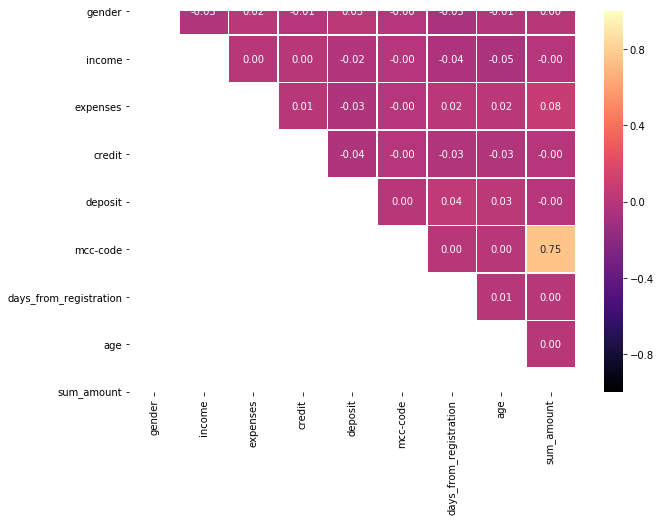

In [105]:
columns = ['gender', 'income', 'expenses', 'credit', 'deposit', 'mcc-code', 'days_from_registration', 'age', 'sum_amount', 'subtype', 'product_company']
mask = np.tril(data_train_content[columns].corr())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
sns.heatmap(data_train_content[columns].corr(), linewidth=.5, annot=True, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='magma', linecolor='white', mask=mask, ax=ax)
fig.savefig(r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\graphics\correlation_matrix.png")
plt.show()

По данной матрице корреляции можно сделать вывод о том, что в данных отсутствует проблема мультиколлинеарности.

In [106]:
data_train_content = pd.get_dummies(data_train_content, columns=['gender', 'subtype', 'product_company'], drop_first=True)
data_train_content.head()

,client_id,last_date,product_category,purchase_normalize,mcc-code,income,expenses,credit,deposit,sum_amount,...,product_company_Стрелка,product_company_Тануки,product_company_Театр Волшебный Фонар,product_company_Утконос Онлайн,product_company_Читай-город,product_company_Якитория,product_company_Яндекс.Драйв,product_company_Яндекс.Лавка,product_company_Яндекс.Музыка,product_company_ЯндексGO
0,1,2020-12-22 02:33:13,10,0.042607,15,230910.0,61975,1,0,9707.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2020-12-22 10:20:44,11,0.032581,4,230910.0,61975,1,0,21380.0,...,0,0,0,0,0,0,0,0,0,0
2,1,2020-12-29 09:07:06,13,0.055138,20,230910.0,61975,1,0,130068.0,...,0,0,0,0,0,0,0,0,0,0
3,1,2020-12-29 03:38:07,16,0.022556,2,230910.0,61975,1,0,7885.0,...,0,0,0,0,0,0,0,0,0,0
4,1,2020-11-11 05:21:46,17,0.012531,37,230910.0,61975,1,0,122239.0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
data_test_content = pd.get_dummies(data_test_content, columns=['gender', 'subtype', 'product_company'], drop_first=True)
data_test_content.head()

,client_id,product_category,mcc-code,birthdate,registration_date,income,expenses,credit,deposit,sum_amount,...,product_company_Стрелка,product_company_Тануки,product_company_Театр Волшебный Фонар,product_company_Утконос Онлайн,product_company_Читай-город,product_company_Якитория,product_company_Яндекс.Драйв,product_company_Яндекс.Лавка,product_company_Яндекс.Музыка,product_company_ЯндексGO
0,1,1,2,1966-09-07,2017-01-10,230910.0,61975,1,0,45554.114248,...,0,0,0,0,0,0,0,0,0,0
1,1,2,12,1966-09-07,2017-01-10,230910.0,61975,1,0,124999.000000,...,0,0,0,0,0,0,0,0,0,0
2,1,3,1,1966-09-07,2017-01-10,230910.0,61975,1,0,45554.114248,...,0,0,0,0,0,0,0,0,0,0
3,1,4,2,1966-09-07,2017-01-10,230910.0,61975,1,0,1908.000000,...,0,0,0,0,0,0,0,0,0,0
4,1,5,1,1966-09-07,2017-01-10,230910.0,61975,1,0,57310.000000,...,0,0,0,0,0,0,0,0,0,0


In [108]:
X_train_content = data_train_content[data_train_content.columns[features_start:]]
y_train_content = np.array(data_train_content.purchase_normalize > 0, dtype=int)

#### 3.4.2. RandomForestClassifier

In [109]:
model_forest = RandomForestClassifier(random_state=7)
model_forest.fit(X_train_content, y_train_content)

RandomForestClassifier(random_state=7)

In [110]:
predictions = model_forest.predict_proba(data_test_content[data_train_content.columns[features_start:]])[:, 1]
data_test_content['predictions'] = predictions

data_test_content = data_test_content.sort_values('predictions', ascending=False)
predictions = data_test_content.groupby('client_id')['product_category'].agg(list)
tmp_predictions = []

for client_id in tqdm_notebook(data_true.index):
    prediction = np.array(predictions[int(client_id) - 1])
    
    tmp_predictions.append(
        list(prediction)[:top_k]) #***
    
data_true['prediction_content_forest'] = tmp_predictions

In [111]:
print(f'Precision@1: {calc_precision("prediction_content_forest")}')
print(f'Recall@1: {calc_recall("prediction_content_forest")}')
print(f'F-score@1: {calc_fscore_precision("prediction_content_forest")}')

Precision@1: 0.081
Recall@1: 0.081
F-score@1: 0.081


#### 3.4.3. CatBoostClassifier

In [112]:
model_cat = catboost.CatBoostClassifier(random_state=7)
model_cat.fit(X_train_content, y_train_content)

Learning rate set to 0.051613
0:	learn: 0.6707136	total: 207ms	remaining: 3m 27s
1:	learn: 0.6551229	total: 222ms	remaining: 1m 50s
2:	learn: 0.6432420	total: 237ms	remaining: 1m 18s
3:	learn: 0.6271728	total: 253ms	remaining: 1m 3s
4:	learn: 0.6185484	total: 269ms	remaining: 53.6s
5:	learn: 0.6114585	total: 284ms	remaining: 47s
6:	learn: 0.6058851	total: 297ms	remaining: 42.1s
7:	learn: 0.5972344	total: 312ms	remaining: 38.7s
8:	learn: 0.5936127	total: 327ms	remaining: 36s
9:	learn: 0.5901154	total: 340ms	remaining: 33.7s
10:	learn: 0.5869042	total: 356ms	remaining: 32s
11:	learn: 0.5852960	total: 371ms	remaining: 30.5s
12:	learn: 0.5847884	total: 381ms	remaining: 28.9s
13:	learn: 0.5831339	total: 395ms	remaining: 27.8s
14:	learn: 0.5805233	total: 414ms	remaining: 27.2s
15:	learn: 0.5791155	total: 430ms	remaining: 26.5s
16:	learn: 0.5775771	total: 446ms	remaining: 25.8s
17:	learn: 0.5752433	total: 462ms	remaining: 25.2s
18:	learn: 0.5745430	total: 476ms	remaining: 24.6s
19:	learn: 0.5

160:	learn: 0.5560988	total: 2.8s	remaining: 14.6s
161:	learn: 0.5560962	total: 2.82s	remaining: 14.6s
162:	learn: 0.5560919	total: 2.83s	remaining: 14.5s
163:	learn: 0.5560877	total: 2.85s	remaining: 14.5s
164:	learn: 0.5560655	total: 2.86s	remaining: 14.5s
165:	learn: 0.5560617	total: 2.88s	remaining: 14.5s
166:	learn: 0.5560593	total: 2.9s	remaining: 14.5s
167:	learn: 0.5559946	total: 2.92s	remaining: 14.5s
168:	learn: 0.5559902	total: 2.94s	remaining: 14.5s
169:	learn: 0.5559832	total: 2.97s	remaining: 14.5s
170:	learn: 0.5559682	total: 2.98s	remaining: 14.5s
171:	learn: 0.5555376	total: 3s	remaining: 14.5s
172:	learn: 0.5555235	total: 3.02s	remaining: 14.4s
173:	learn: 0.5555024	total: 3.03s	remaining: 14.4s
174:	learn: 0.5554988	total: 3.05s	remaining: 14.4s
175:	learn: 0.5554919	total: 3.06s	remaining: 14.3s
176:	learn: 0.5554825	total: 3.07s	remaining: 14.3s
177:	learn: 0.5554546	total: 3.09s	remaining: 14.3s
178:	learn: 0.5554483	total: 3.1s	remaining: 14.2s
179:	learn: 0.5554

319:	learn: 0.5527332	total: 5.53s	remaining: 11.8s
320:	learn: 0.5527249	total: 5.54s	remaining: 11.7s
321:	learn: 0.5527100	total: 5.56s	remaining: 11.7s
322:	learn: 0.5526914	total: 5.58s	remaining: 11.7s
323:	learn: 0.5526651	total: 5.61s	remaining: 11.7s
324:	learn: 0.5526587	total: 5.63s	remaining: 11.7s
325:	learn: 0.5526472	total: 5.66s	remaining: 11.7s
326:	learn: 0.5526431	total: 5.68s	remaining: 11.7s
327:	learn: 0.5526386	total: 5.7s	remaining: 11.7s
328:	learn: 0.5526316	total: 5.72s	remaining: 11.7s
329:	learn: 0.5526301	total: 5.74s	remaining: 11.7s
330:	learn: 0.5526233	total: 5.77s	remaining: 11.7s
331:	learn: 0.5526179	total: 5.79s	remaining: 11.6s
332:	learn: 0.5526029	total: 5.81s	remaining: 11.6s
333:	learn: 0.5525989	total: 5.82s	remaining: 11.6s
334:	learn: 0.5525907	total: 5.84s	remaining: 11.6s
335:	learn: 0.5525878	total: 5.86s	remaining: 11.6s
336:	learn: 0.5525843	total: 5.88s	remaining: 11.6s
337:	learn: 0.5525791	total: 5.9s	remaining: 11.6s
338:	learn: 0.

478:	learn: 0.5513773	total: 8.38s	remaining: 9.11s
479:	learn: 0.5513759	total: 8.39s	remaining: 9.09s
480:	learn: 0.5513731	total: 8.41s	remaining: 9.08s
481:	learn: 0.5513632	total: 8.43s	remaining: 9.06s
482:	learn: 0.5513614	total: 8.45s	remaining: 9.04s
483:	learn: 0.5513587	total: 8.46s	remaining: 9.02s
484:	learn: 0.5513501	total: 8.48s	remaining: 9s
485:	learn: 0.5513428	total: 8.49s	remaining: 8.98s
486:	learn: 0.5513134	total: 8.51s	remaining: 8.96s
487:	learn: 0.5513122	total: 8.52s	remaining: 8.94s
488:	learn: 0.5513093	total: 8.54s	remaining: 8.92s
489:	learn: 0.5512993	total: 8.55s	remaining: 8.9s
490:	learn: 0.5512912	total: 8.57s	remaining: 8.88s
491:	learn: 0.5512865	total: 8.58s	remaining: 8.86s
492:	learn: 0.5512831	total: 8.6s	remaining: 8.84s
493:	learn: 0.5512790	total: 8.61s	remaining: 8.82s
494:	learn: 0.5512653	total: 8.63s	remaining: 8.8s
495:	learn: 0.5512608	total: 8.65s	remaining: 8.79s
496:	learn: 0.5512585	total: 8.66s	remaining: 8.77s
497:	learn: 0.5512

637:	learn: 0.5501688	total: 11.1s	remaining: 6.32s
638:	learn: 0.5501629	total: 11.2s	remaining: 6.3s
639:	learn: 0.5501586	total: 11.2s	remaining: 6.28s
640:	learn: 0.5501580	total: 11.2s	remaining: 6.26s
641:	learn: 0.5501519	total: 11.2s	remaining: 6.25s
642:	learn: 0.5501496	total: 11.2s	remaining: 6.23s
643:	learn: 0.5501489	total: 11.2s	remaining: 6.21s
644:	learn: 0.5501281	total: 11.3s	remaining: 6.2s
645:	learn: 0.5501219	total: 11.3s	remaining: 6.18s
646:	learn: 0.5501120	total: 11.3s	remaining: 6.16s
647:	learn: 0.5501082	total: 11.3s	remaining: 6.14s
648:	learn: 0.5500932	total: 11.3s	remaining: 6.13s
649:	learn: 0.5500899	total: 11.3s	remaining: 6.11s
650:	learn: 0.5500849	total: 11.4s	remaining: 6.09s
651:	learn: 0.5500809	total: 11.4s	remaining: 6.07s
652:	learn: 0.5500775	total: 11.4s	remaining: 6.05s
653:	learn: 0.5500731	total: 11.4s	remaining: 6.03s
654:	learn: 0.5500704	total: 11.4s	remaining: 6.01s
655:	learn: 0.5500671	total: 11.4s	remaining: 6s
656:	learn: 0.550

796:	learn: 0.5494119	total: 13.8s	remaining: 3.52s
797:	learn: 0.5494087	total: 13.8s	remaining: 3.5s
798:	learn: 0.5494054	total: 13.8s	remaining: 3.48s
799:	learn: 0.5494024	total: 13.9s	remaining: 3.46s
800:	learn: 0.5494002	total: 13.9s	remaining: 3.45s
801:	learn: 0.5493956	total: 13.9s	remaining: 3.43s
802:	learn: 0.5493902	total: 13.9s	remaining: 3.41s
803:	learn: 0.5493886	total: 13.9s	remaining: 3.4s
804:	learn: 0.5493598	total: 13.9s	remaining: 3.38s
805:	learn: 0.5493561	total: 14s	remaining: 3.36s
806:	learn: 0.5493544	total: 14s	remaining: 3.34s
807:	learn: 0.5493513	total: 14s	remaining: 3.33s
808:	learn: 0.5493496	total: 14s	remaining: 3.31s
809:	learn: 0.5493457	total: 14s	remaining: 3.29s
810:	learn: 0.5493354	total: 14s	remaining: 3.27s
811:	learn: 0.5493328	total: 14.1s	remaining: 3.26s
812:	learn: 0.5493314	total: 14.1s	remaining: 3.24s
813:	learn: 0.5493237	total: 14.1s	remaining: 3.22s
814:	learn: 0.5493191	total: 14.1s	remaining: 3.21s
815:	learn: 0.5493134	tota

955:	learn: 0.5487191	total: 16.5s	remaining: 761ms
956:	learn: 0.5487172	total: 16.5s	remaining: 743ms
957:	learn: 0.5487144	total: 16.6s	remaining: 726ms
958:	learn: 0.5486880	total: 16.6s	remaining: 709ms
959:	learn: 0.5486851	total: 16.6s	remaining: 691ms
960:	learn: 0.5486833	total: 16.6s	remaining: 674ms
961:	learn: 0.5486782	total: 16.6s	remaining: 656ms
962:	learn: 0.5486735	total: 16.6s	remaining: 639ms
963:	learn: 0.5486681	total: 16.6s	remaining: 622ms
964:	learn: 0.5486666	total: 16.7s	remaining: 604ms
965:	learn: 0.5486661	total: 16.7s	remaining: 587ms
966:	learn: 0.5486638	total: 16.7s	remaining: 570ms
967:	learn: 0.5486491	total: 16.7s	remaining: 552ms
968:	learn: 0.5486481	total: 16.7s	remaining: 535ms
969:	learn: 0.5486479	total: 16.7s	remaining: 518ms
970:	learn: 0.5486456	total: 16.8s	remaining: 500ms
971:	learn: 0.5486438	total: 16.8s	remaining: 483ms
972:	learn: 0.5486426	total: 16.8s	remaining: 466ms
973:	learn: 0.5486403	total: 16.8s	remaining: 449ms
974:	learn: 

In [113]:
predictions = model_cat.predict_proba(data_test_content[data_train_content.columns[features_start:]])[:, 1]
data_test_content['predictions'] = predictions

data_test_content = data_test_content.sort_values('predictions', ascending=False)
predictions = data_test_content.groupby('client_id')['product_category'].agg(list)
tmp_predictions = []

for client_id in tqdm_notebook(data_true.index):
    prediction = np.array(predictions[int(client_id) - 1])
    
    tmp_predictions.append(
        list(prediction)[:top_k]) #***
    
data_true['prediction_content'] = tmp_predictions

In [114]:
print(f'Precision@1: {calc_precision("prediction_content")}')
print(f'Recall@1: {calc_recall("prediction_content")}')
print(f'F-score@1: {calc_fscore_precision("prediction_content")}')

Precision@1: 0.032
Recall@1: 0.032
F-score@1: 0.032


### 3.5. Сравнение memory-based и LFM моделей

Для выбора итоговой модели посмотрим на качество данных моделей при рекомендации большего количества категорий, чем 1 - 2-5.

In [115]:
top_k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]

#### Memory-based

In [116]:
fscore_memory_based = []
for top_k in top_k_list:
    prediction_user_based = []
    for i in range(len(similarity_users)):
        users_sim = similarity_users[i] > 0
        if len(users_sim) == 0:
            prediction_user_based.append([])
        else:
            tmp_recommend = np.argsort(matrix[users_sim].sum(axis=0))[::-1]
            tmp_recommend = data_matrix.columns[tmp_recommend]
            recommend = np.array(tmp_recommend)[:top_k] #***
            prediction_user_based.append(list(recommend))

    data_true['prediction_user_based'] = prediction_user_based
    fscore_memory_based.append(calc_fscore_precision("prediction_user_based"))

#### Latent Factor Model

In [117]:
fscore_lfm = []
for top_k in top_k_list:
    new_data_matrix = pd.DataFrame(new_data_matrix, index=data_matrix.index, columns=data_matrix.columns)

    predictions = []
    for client_id in data_true.index:
        prediction = (
            new_data_matrix
            .loc[client_id]
            .sort_values(ascending=False)
            .index.values
        )
        predictions.append(
            list(prediction)[:top_k]) #***

    data_true['prediction_svd'] = predictions
    fscore_lfm.append(calc_fscore_precision("prediction_svd"))

In [118]:
sns.set(style='whitegrid')

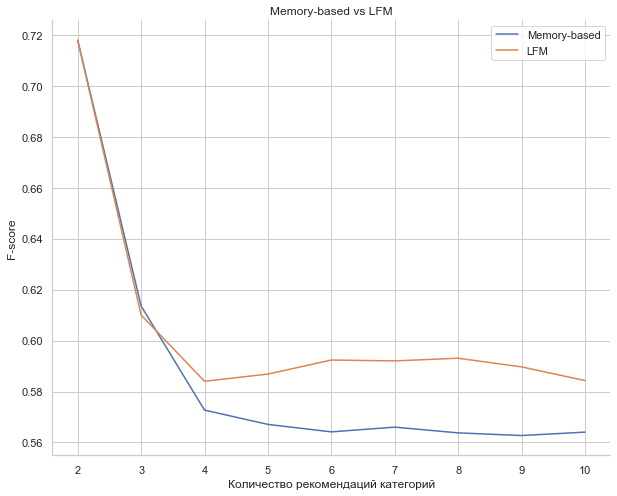

In [119]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x=top_k_list, y=fscore_memory_based, ax=ax, label='Memory-based')
sns.lineplot(x=top_k_list, y=fscore_lfm, ax=ax, label='LFM')
ax.set_title('Memory-based vs LFM')
ax.set_xlabel('Количество рекомендаций категорий')
ax.set_ylabel('F-score')
sns.despine()
fig.savefig(r"C:\Users\kiril\OneDrive\Рабочий стол\Вышка\КР-ВКР\Курсовая\3 курс\RecommendationSystem\model\graphics\comparison_models.png")
plt.show()

LFM показывает лучшее качество метрики F-score на больших количествах рекомендаций, чем Memory-based поэтому возьмем ее за итоговую модель рекомендательной системы.